### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import random
import pandas as pd
import os
import sys

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator

In [6]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.population.networks.city import CityPopulation
from codit.population.covid import PersonCovid
import codit.society as society
import codit.config

### Baseline config of the simulation

In [7]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {'other': {'other'}, 'SARS-CoV-2': {'SARS-CoV-2', 'B.1.1.7'}, 'B.1.1.7': {'SARS-CoV-2', 'B.1.1.7'}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID SARS-CoV-2
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {'SARS-CoV-2': 0.025, 'B.1.1.7': 0.039}
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
VACCINATION_IMMUNITY {'AstraZeneca': {'SARS-CoV-2', 'B.1.1.7'}, 'Pfizer': {'SARS-CoV-2', 'B.1.1.7'}}
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We are going to work with a small town of a few thousand people.

In [8]:
pop = CityPopulation(560000, society.Society())

2021-03-28 19:59:40,688 INFO:Building a set of 224000 households from which to build a population
2021-03-28 20:00:33,047 INFO:220051 households of mean size 2.54
2021-03-28 20:00:35,895 INFO:101252 buildings of mean size 5.53
2021-03-28 20:01:00,548 INFO:1461 classrooms of mean size 28.87
2021-03-28 20:01:00,792 INFO:99 care_homes of mean size 105.68
2021-03-28 20:01:01,845 INFO:65449 workplaces of mean size 5.62
2021-03-28 20:01:07,712 INFO:0% of workplaces closed by lockdown, leaving 54869 open, of average Income Decile 5.07 (and st dev 3.13).
2021-03-28 20:01:07,878 INFO:0% of classrooms closed by lockdown, leaving 1185 open, of average Income Decile 4.75 (and st dev 3.10).
2021-03-28 20:01:07,912 INFO:Adding 276204 permanent contact groups
2021-03-28 20:01:08,060 INFO:Adding 28000 ephemeral contact pairs
2021-03-28 20:01:08,845 INFO:Adding 168417 contacts each within one of the 101252 buildings (contact density of 0.75)


Randomly, we put them into fixed and overlapping social groupings, where each person has a small network.

In [9]:
nets = [len(p.contacts) for p in pop.people]

In [10]:
np.mean(nets)

12.799253571428572

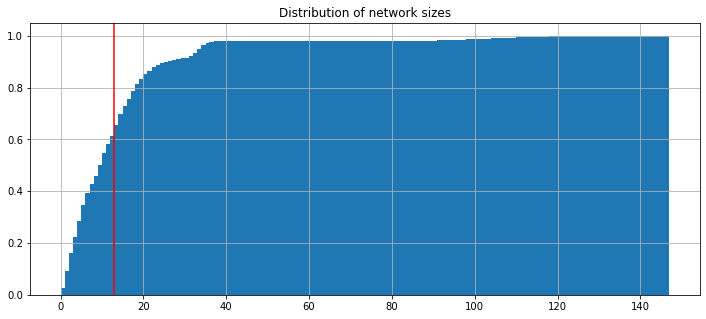

In [11]:
plt.hist(nets, cumulative=True, density=True, bins=2000)
plt.title('Distribution of network sizes')
plt.axvline(np.mean(nets), color='r')
plt.grid()

### Finally ready to simulate:

We will place the population that we have created, into various settings and societies in the upcoming simulations

In [14]:
POP_SIZE = len(pop.people)
PREVALENCE = 1/560 * 4
SCALE_SETTINGS = dict(n_days = 201, pop_size = POP_SIZE, seed_size = int(POP_SIZE*PREVALENCE), population=pop)
SCALE_SETTINGS

{'n_days': 201,
 'pop_size': 560000,
 'seed_size': 4000,
 'population': <codit.population.networks.city.CityPopulation at 0x2442d9d2670>}

Our baseline simulation is of a runaway infection.

We start with 400 people infected in a population of 56,000.

We begin by studying a society where people don't know whether or how to self-isolate:

In [15]:
s_basic = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0))
o_basic = Outbreak(s_basic, Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 20:02:54,489 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-03-28 20:04:59,420 INFO:Day 51, prop infected is 0.43, prop infectious is 0.0837
2021-03-28 20:06:35,659 INFO:Day 101, prop infected is 0.57, prop infectious is 0.0029
2021-03-28 20:07:56,647 INFO:Day 151, prop infected is 0.57, prop infectious is 0.0000
2021-03-28 20:09:11,730 INFO:Day 201, prop infected is 0.57, prop infectious is 0.0000


2021-03-28 20:38:36,570 INFO: Realized R0 of early infections is 1.48
2021-03-28 20:38:36,570 INFO: 56.8 percent of the population was infected during the epidemic


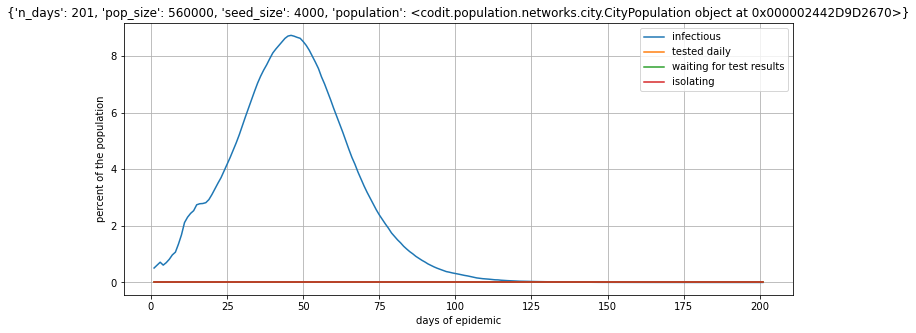

In [16]:
o_basic.plot(title=str(SCALE_SETTINGS))

Lets put that on a log scale:

2021-03-28 20:38:40,830 INFO: Realized R0 of early infections is 1.48
2021-03-28 20:38:40,831 INFO: 56.8 percent of the population was infected during the epidemic


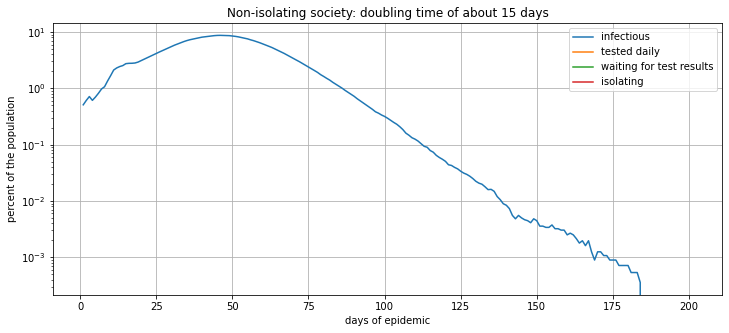

In [17]:
o_basic.plot(logy=True, title='Non-isolating society: doubling time of about 15 days')

Next, suppose that people know to isolate if they show symptoms, and 75% do so - this is similar to what is going on in the UK now:

In [18]:
s_isolate = society.Society(config=dict(PROB_ISOLATE_IF_SYMPTOMS = 0.75))
o_isolate = Outbreak(s_isolate, Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 20:38:50,881 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0050
2021-03-28 20:40:28,641 INFO:Day 51, prop infected is 0.12, prop infectious is 0.0185
2021-03-28 20:42:04,912 INFO:Day 101, prop infected is 0.23, prop infectious is 0.0124
2021-03-28 20:43:29,905 INFO:Day 151, prop infected is 0.27, prop infectious is 0.0024
2021-03-28 20:44:59,964 INFO:Day 201, prop infected is 0.28, prop infectious is 0.0003


2021-03-28 20:45:01,048 INFO: Realized R0 of early infections is 1.14
2021-03-28 20:45:01,049 INFO: 27.5 percent of the population was infected during the epidemic


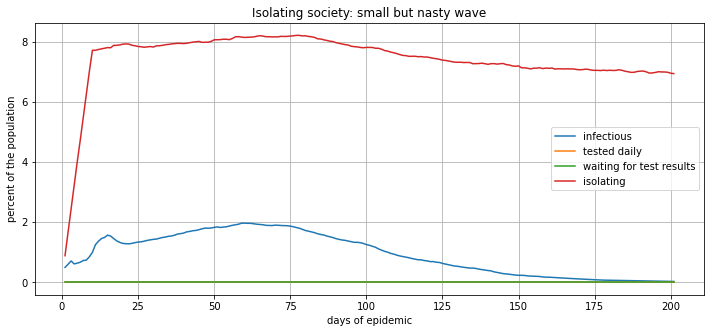

In [19]:
o_isolate.plot(title='Isolating society: small but nasty wave')

So, now we can add testing:
 * initially, here, lets suppose that positive test results are just ignored, while -ve results let people out of isolation:

In [20]:
s_testignored = society.TestingSociety(config=dict(PROB_ISOLATE_IF_TESTPOS=0))
o_testignored = Outbreak(s_testignored, Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 20:45:12,372 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-03-28 20:47:45,884 INFO:Day 51, prop infected is 0.15, prop infectious is 0.0258
2021-03-28 20:50:28,572 INFO:Day 101, prop infected is 0.29, prop infectious is 0.0121
2021-03-28 20:52:15,845 INFO:Day 151, prop infected is 0.32, prop infectious is 0.0017
2021-03-28 20:54:02,208 INFO:Day 201, prop infected is 0.32, prop infectious is 0.0002


2021-03-28 20:54:03,948 INFO: Realized R0 of early infections is 1.21
2021-03-28 20:54:03,950 INFO: 31.9 percent of the population was infected during the epidemic


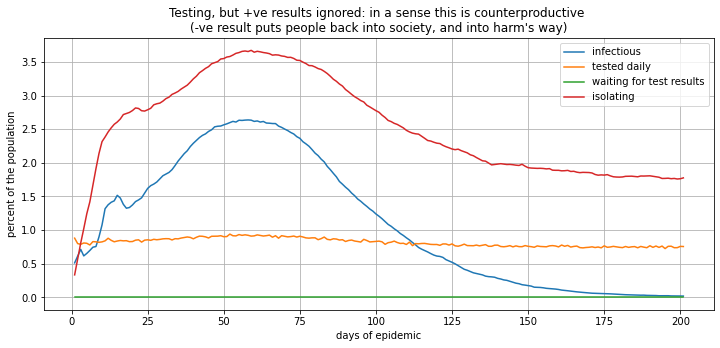

In [21]:
o_testignored.plot(title="Testing, but +ve results ignored: in a sense this is counterproductive \n"
                         "(-ve result puts people back into society, and into harm's way)")

 * Now suppose that people respond to test results, some of the time:

In [22]:
o_test = Outbreak(society.TestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 20:54:19,283 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-03-28 20:56:45,653 INFO:Day 51, prop infected is 0.14, prop infectious is 0.0236
2021-03-28 20:59:09,528 INFO:Day 101, prop infected is 0.27, prop infectious is 0.0112
2021-03-28 21:01:19,550 INFO:Day 151, prop infected is 0.30, prop infectious is 0.0019
2021-03-28 21:03:18,872 INFO:Day 201, prop infected is 0.31, prop infectious is 0.0002


2021-03-28 21:03:20,224 INFO: Realized R0 of early infections is 1.16
2021-03-28 21:03:20,225 INFO: 30.5 percent of the population was infected during the epidemic


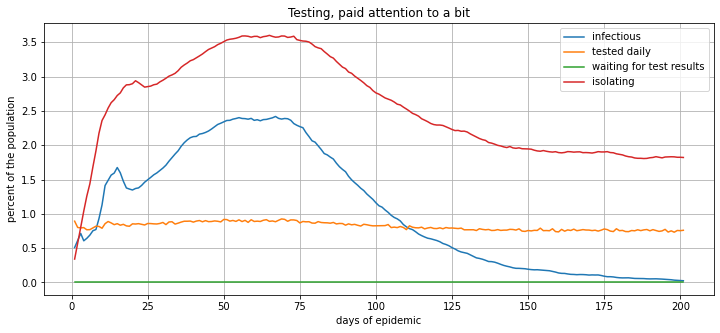

In [23]:
o_test.plot(title="Testing, paid attention to a bit")

We add contact-tracing and isolation:

In [24]:
o_test_trace = Outbreak(society.TestingTracingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 21:03:38,865 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-03-28 21:06:21,475 INFO:Day 51, prop infected is 0.06, prop infectious is 0.0057
2021-03-28 21:08:34,633 INFO:Day 101, prop infected is 0.08, prop infectious is 0.0028
2021-03-28 21:10:56,247 INFO:Day 151, prop infected is 0.10, prop infectious is 0.0011
2021-03-28 21:12:59,842 INFO:Day 201, prop infected is 0.10, prop infectious is 0.0005


2021-03-28 21:13:00,473 INFO: Realized R0 of early infections is 0.97
2021-03-28 21:13:00,474 INFO: 10.1 percent of the population was infected during the epidemic


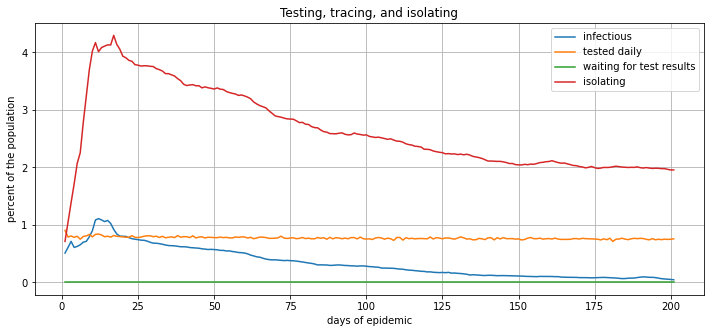

In [25]:
o_test_trace.plot(title='Testing, tracing, and isolating', secondary_y=['prop_infected'])

UK society, however, is characterized by testing bottlenecks:

In [26]:
import codit.society.alternatives as alternatives
o_UK = Outbreak(alternatives.UKSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 21:13:17,203 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0052
2021-03-28 21:15:32,482 INFO:Day 51, prop infected is 0.07, prop infectious is 0.0076
2021-03-28 21:17:51,854 INFO:Day 101, prop infected is 0.11, prop infectious is 0.0041
2021-03-28 21:20:18,813 INFO:Day 151, prop infected is 0.13, prop infectious is 0.0018
2021-03-28 21:22:27,685 INFO:Day 201, prop infected is 0.13, prop infectious is 0.0006


2021-03-28 21:22:28,673 INFO: Realized R0 of early infections is 0.99
2021-03-28 21:22:28,675 INFO: 13.5 percent of the population was infected during the epidemic


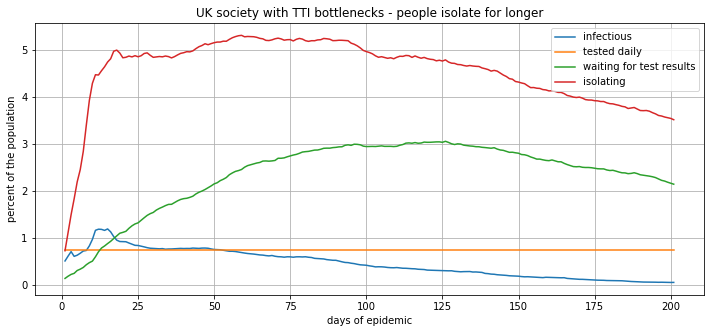

In [27]:
o_UK.plot(title='UK society with TTI bottlenecks - people isolate for longer')

In [28]:
o_contact_test = Outbreak(society.ContactTestingSociety(), Covid(), **SCALE_SETTINGS).simulate()

2021-03-28 21:22:55,999 INFO:Day 1, prop infected is 0.01, prop infectious is 0.0051
2021-03-28 21:25:54,222 INFO:Day 51, prop infected is 0.09, prop infectious is 0.0138
2021-03-28 21:28:31,299 INFO:Day 101, prop infected is 0.17, prop infectious is 0.0091
2021-03-28 21:30:52,072 INFO:Day 151, prop infected is 0.21, prop infectious is 0.0027
2021-03-28 21:32:50,935 INFO:Day 201, prop infected is 0.21, prop infectious is 0.0007


2021-03-28 21:32:51,997 INFO: Realized R0 of early infections is 1.08
2021-03-28 21:32:51,998 INFO: 21.4 percent of the population was infected during the epidemic


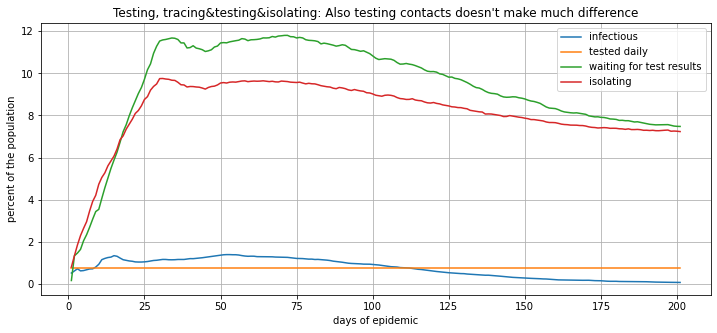

In [29]:
o_contact_test.plot(title="Testing, tracing&testing&isolating: "
                    "Also testing contacts doesn't make much difference", 
                    secondary_y=['prop_infected'])

In [30]:
census = pop.census
infector_nets = [len(census[p.infectors[0]].contacts) for p in pop.people if p.infectors]

In [31]:
infected_nets = [len(p.contacts) for p in pop.people if p.infected]

In [39]:
def most_connected_infector(guy):
    if len(guy.infectors) == 0:
        raise NotImplementedError
    return max([len(i.contacts) for i in guy.chain(census) if i is not guy]) 

max_contacts_chain = [most_connected_infector(person)
                      for person in pop.people 
                      if len(person.infectors)]

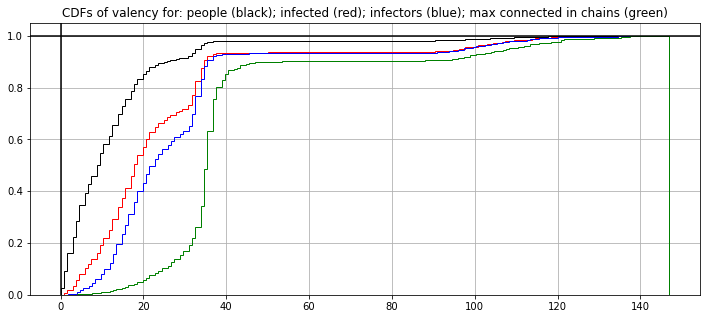

In [33]:
opts = dict(cumulative=True, bins=200, density=True, histtype='step')

plt.hist(nets, color='k', **opts)
plt.hist(infected_nets, color='r', **opts)
plt.hist(infector_nets, color='b', **opts)
plt.hist(max_contacts_chain, color='g', **opts)

plt.title("CDFs of valency for: people (black); infected (red); infectors (blue); max connected in chains (green)")
plt.axhline(1, color='k'); plt.axvline(0, color='k')
plt.grid()